In [69]:
import autograd.numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import pandas as pd
import seaborn as sns

# implort functions from the file in the folder new_NN_from_notes
# reload the file if it has been updated
import importlib
import neural_network
importlib.reload(neural_network)
from neural_network import *

import plotting
importlib.reload(plotting)
from plotting import *

%matplotlib inline

seed = 2024
np.random.seed(seed)


In [2]:
def FrankeFunction(x, y):
    """
    Compute the Franke function value for given x and y.

    Parameters:
    x (ndarray): Input array for x values.
    y (ndarray): Input array for y values.

    Returns:
    ndarray: Computed Franke function values.
    """
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4


def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int((i) * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x ** (i - k)) * (y**k)

    return X

def easy_func(x, y):
    return x**2 + y**2

In [3]:
N = 25
noise_eps = 0.1
deg = 5
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
X, Y = np.meshgrid(x, y)
Z = FrankeFunction(X, Y)
# Z = easy_func(X, Y)
D = create_X(X, Y, deg)
'''NOTE: Not scaling here since it didn't produce nice plots'''

ols = LinearRegression()
ols.fit(D, Z.ravel())
Z_pred = ols.predict(D).reshape(Z.shape)

# Add white Gaussian noise to the surface
# Z = Z + np.random.normal(0, 1, size=Z.shape) * noise_eps



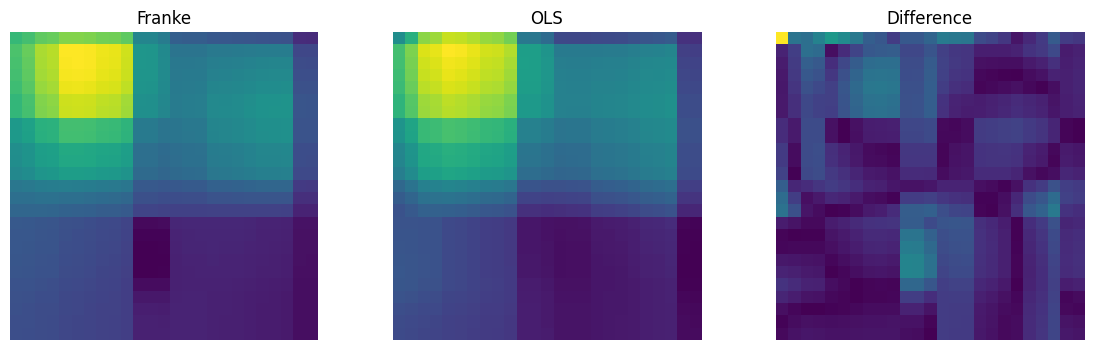

In [4]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title('Franke')
plt.imshow(Z, cmap='viridis', interpolation='none')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('OLS')
plt.imshow(Z_pred, cmap='viridis', interpolation='none')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(abs(Z-Z_pred), cmap='viridis', interpolation='none')
plt.axis('off')

plt.show()

In [5]:
target = Z
target = target.reshape(-1, 1)

# combine the x and y into a single input matrix
input = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
# input = D
X_train, X_test, t_train, t_test = train_test_split(input, target)
inputs = X_train
input_nodes = input.shape[1]
output_nodes = target.shape[1]

# linear_regression = FFNN((input_nodes, output_nodes), output_func=identity, cost_func=CostOLS, seed=seed)
linear_regression = FFNN((input_nodes, 8, output_nodes), hidden_func=sigmoid, output_func=identity, cost_func=CostOLS, seed=seed)
linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

# NOTE: Plotting all just to make sure, comment out if it takes too long
#       Or if you only want some schedulers, just comment out the ones you don't want below
schedulers = [
    Constant (eta=1e-5),
    Adagrad  (eta=1e-5),
    RMS_prop (eta=1e-5),
    Momentum (eta=1e-5),
    Adam     (eta=1e-5)
]
scores = []
preds = []
for scheduler in schedulers:
    linear_regression.reset_weights()
    scores.append(linear_regression.fit(input, target, scheduler, epochs = 1000, batches=10))
    preds.append(linear_regression.predict(input))

Constant: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0976 Adagrad: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0874 RMS_prop: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0635 Momentum: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0852 Adam: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0454 

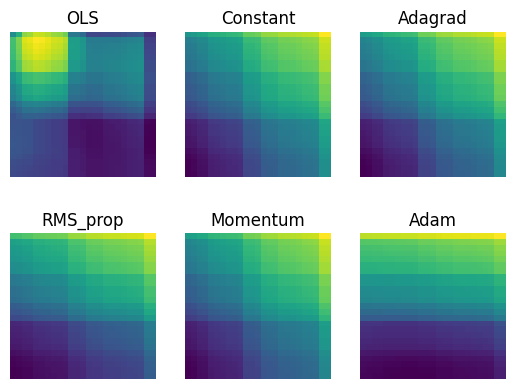

In [6]:
# NOTE: Plotting all in same subplot, this can be easily changed by commenting some lines
plt.subplot(2,3,1)
plt.imshow(Z_pred, cmap='viridis', interpolation='none')
plt.title('OLS')
plt.axis('off')
for i, scheduler in enumerate(schedulers):
    pred = preds[i].reshape(Z.shape)
    name = type(scheduler).__name__
    plt.subplot(2,3,i+2) # Comment out for seperate plots
    plt.title(name)
    plt.imshow(pred, cmap='viridis', interpolation='none')
    plt.axis('off')
    #plt.savefig(f'../figures/{name}_franke_function.pdf') # Uncomment for seperate plots
plt.savefig('../figures/Comparison_Franke_function_all_schedulers.pdf') # Comment for seperate plots

## Comparing GD and SGD using OLS and Ridge
In this analysis we include a comparison of GD and SGD scores including the following: 
- GD with different schedulers for OLS and Ridge
- SGD with different schedulers for OLS and Ridge
- Show both MSE and R2 score


In [7]:
# Define the data for linear regression
# including the input design matrix and the target
N = 25
noise_eps = 0.1
deg = 8
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
X, Y = np.meshgrid(x, y)
Z = FrankeFunction(X, Y)
# Z = easy_func(X, Y)
D = create_X(X, Y, deg)

In [8]:
input_train, input_test, target_train, target_test = train_test_split(D, Z.reshape(-1, 1), test_size=0.2)

# Scaling of the data
scaler = StandardScaler()
input_train = scaler.fit_transform(input_train)
input_test = scaler.transform(input_test)
target_train = scaler.fit_transform(target_train)
taget_test = scaler.transform(target_test)

# Define the network for linear regression using no hidden layers
input_nodes = input_train.shape[1]
output_nodes = 1

linreg = FFNN((input_nodes, output_nodes), output_func=identity, cost_func=CostOLS, seed=seed)

In [9]:
# Compute the analytical solution using scikit-learn
ols = LinearRegression()
ols.fit(input_train, target_train)
ols_pred = ols.predict(input_test)
mse_train = np.mean((ols.predict(input_train) - target_train)**2)
mse_test = np.mean((ols_pred - target_test)**2)

In [10]:
print(mse_train, mse_test)

0.0025747028937033543 0.5688325739764349


In [ ]:
# fit the network to the data using the different schedulers and GD 
# with OLS
schedulers = [
    Constant(eta=1e-5),
    Momentum(eta=1e-5),
    Adagrad (eta=1e-5),
    RMS_prop(eta=1e-5),
    Adam    (eta=1e-5)
]
scores_OLS = {}
for scheduler in schedulers:
    linreg.reset_weights()
    name = type(scheduler).__name__
    scores_OLS[name] = linreg.fit(input_train, target_train, scheduler, epochs=5000, batches=1, X_val = input_test, t_val = target_test)
    print()

Constant: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 1.26 | val_error: 0.819  
Momentum: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.396 | val_error: 0.580 
Adagrad: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 1.17 | val_error: 0.725  
RMS_prop: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.403 | val_error: 0.617 
Adam: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.459 | val_error: 0.605 


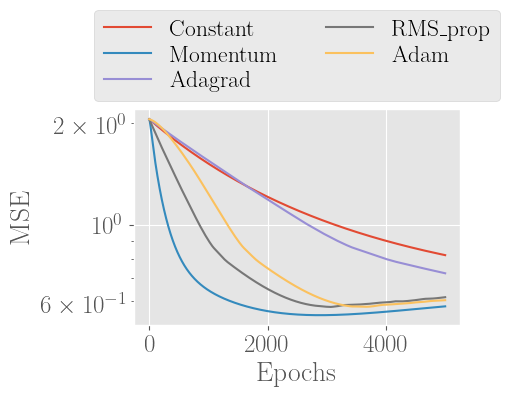

In [92]:
# NOTE: Changed to semilogy for plots below, since it is easier
#       to see the difference between models
# plot the scores for the different schedulers
fig, ax = make_plot('normal-plot')
for name, score in scores_OLS.items():
    plt.semilogy(score['val_errors'], label=name)
#plt.hlines(mse_test, xmin=0, xmax=1000, label='Analytical', color='black', linestyle='--')

plt.legend(bbox_to_anchor=(0.5,1.25), loc='center', labelspacing=0.2, ncols=2, fontsize=17)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('../figures/OLS_GD_schedulers.pdf', bbox_inches='tight')
plt.show()


In [13]:
# Repeat process for SGD (Only change her is that we run with 10 batches instead of 1)
schedulers = [
    Constant(eta=1e-5),
    Momentum(eta=1e-5),
    Adagrad (eta=1e-5),
    RMS_prop(eta=1e-5),
    Adam    (eta=1e-5)
]
scores_OLS_SGD = {}
for scheduler in schedulers:
    linreg.reset_weights()
    name = type(scheduler).__name__
    scores_OLS_SGD[name] = linreg.fit(input_train, target_train, scheduler, epochs=5000, batches=10, X_val = input_test, t_val = target_test)
    print()


Constant: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.396 | val_error: 0.580 
Momentum: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.184 | val_error: 0.580 
Adagrad: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.378 | val_error: 0.656 
RMS_prop: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.156 | val_error: 0.565 
Adam: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0635 | val_error: 0.551 


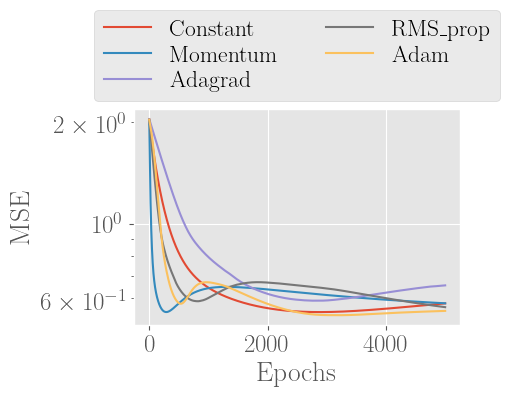

In [91]:
# plot the scores for the different schedulers
fig, ax = make_plot('normal-plot')
for name, score in scores_OLS_SGD.items():
    plt.semilogy(score['val_errors'], label=name)
#plt.hlines(mse_test, xmin=0, xmax=1000, label='Analytical', color='black', linestyle='--')

plt.legend(bbox_to_anchor=(0.5,1.25), loc='center', labelspacing=0.2, ncols=2, fontsize=17)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('../figures/OLS_SGD_schedulers.pdf', bbox_inches='tight')
plt.show()

In [15]:
# using SGD with mini-batches and Adam as the scheduler, we test different regularisation parameters
lams = [0, 1e-5, 1e-4, 1e-3, 1e-2]
scores = []
for lam in lams:
    linreg.reset_weights()
    scores.append(linreg.fit(input_train, target_train, schedulers[-1], epochs=5000, batches=10, X_val = input_test, t_val=target_test, lam=lam))
    print()

Adam: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0635 | val_error: 0.551 
Adam: Eta=1e-05, Lambda=1e-05
  [=======================================>] 100.0% | train_error: 0.0635 | val_error: 0.551 
Adam: Eta=1e-05, Lambda=0.0001
  [=======================================>] 100.0% | train_error: 0.0636 | val_error: 0.551 
Adam: Eta=1e-05, Lambda=0.001
  [=======================================>] 100.0% | train_error: 0.0642 | val_error: 0.547 
Adam: Eta=1e-05, Lambda=0.01
  [=======================================>] 100.0% | train_error: 0.0715 | val_error: 0.516 


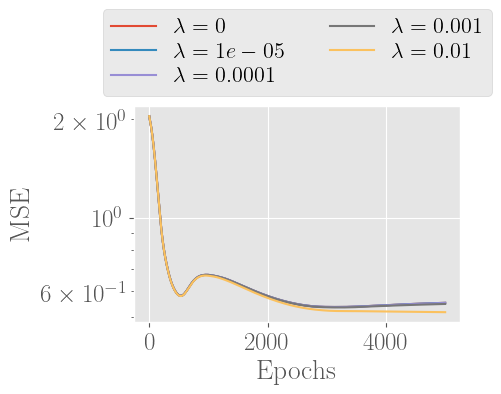

In [ ]:
# plot the scores for the different regularisation parameters
fig, ax = make_plot('normal-plot')
for i, lam in enumerate(lams):
    plt.semilogy(scores[i]['val_errors'], label=f'$\\lambda = {lam}$')
#plt.hlines(mse_test, xmin=0, xmax=1000, label='Analytical', color='black', linestyle='--')
plt.legend(bbox_to_anchor=(0.5,1.25), loc='center', labelspacing=0.2, ncols=2, fontsize=17)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('../figures/OLS_SGD_regularisation.pdf', bbox_inches='tight')
plt.show()

In [17]:
# Now look at how the batch size affects the convergence of SGD with Adam
batches = [1, 10, 50, 100]
scores_bs = []
for batch in batches:
    linreg.reset_weights()
    scores_bs.append(linreg.fit(input_train, target_train, schedulers[-1], epochs=5000, batches=batch, X_val = input_test, t_val=target_test))
    print()

Adam: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.459 | val_error: 0.605 
Adam: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0635 | val_error: 0.551 
Adam: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0528 | val_error: 0.552 
Adam: Eta=1e-05, Lambda=0
  [=======================================>] 100.0% | train_error: 0.0497 | val_error: 0.559 


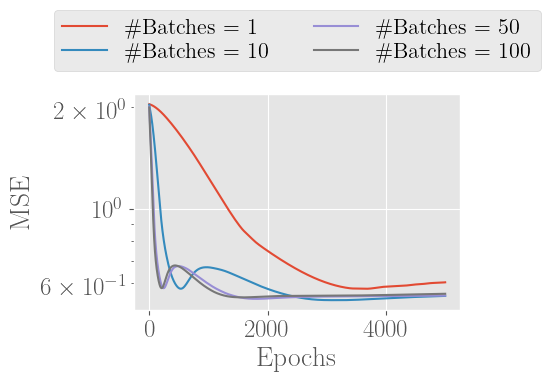

In [ ]:
# plot the scores for the different batch sizes
fig, ax = make_plot('normal-plot')
for i, batch in enumerate(batches):
    plt.semilogy(scores_bs[i]['val_errors'], label=f'\\#Batches = {batch}')
#plt.hlines(mse_test, xmin=0, xmax=1000, label='Analytical', color='black', linestyle='--')
plt.legend(bbox_to_anchor=(0.5,1.25), loc='center', labelspacing=0.2, ncols=2, fontsize=17)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('../figures/OLS_SGD_batch_size.pdf', bbox_inches='tight')
plt.show()

## Tuning the number of hidden layers and the number of nodes in each hidden layer
We test for sigmoid RELU and leaky RELU activations in the hidden layer

In [19]:
# Common parameters for the tuning
N = 25
np.random.seed(seed)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
X, Y = np.meshgrid(x, y)
Z = FrankeFunction(X, Y)

input = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
target = Z.reshape(-1, 1)
input_nodes = input.shape[1]
output_nodes = target.shape[1]

# split data
input_train, input_test, target_train, target_test = train_test_split(input, target, test_size=0.2)
num_nodes = [4, 8, 16, 32, 64]
num_layers = [1, 2, 3, 4, 5]

# define scheduler
scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)

### Sigmoid activation

In [20]:
scores_sigmoid = np.zeros((len(num_nodes), len(num_layers)))
for i, nodes in enumerate(num_nodes):
    for j, layers in enumerate(num_layers):
        print(f'Nodes: {nodes}, Layers: {layers}')
        linear_regression = FFNN((input_nodes, *[nodes]*layers, output_nodes), hidden_func=sigmoid, output_func=identity, cost_func=CostOLS, seed=seed)
        linear_regression.reset_weights()
        result = linear_regression.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=1000, batches=10)
        scores_sigmoid[i, j] = result['val_errors'][-1]  # Adjust this line based on the actual key in the returned dictionary
        print(f'{nodes=}, {layers=}')
clear_output()
print('Finished!')

Finished!


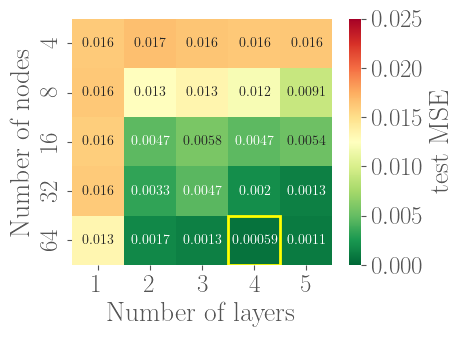

In [ ]:
import matplotlib.ticker as ticker
num_nodes = [4, 8, 16, 32, 64]
num_layers = [1, 2, 3, 4, 5]

_, fig = make_plot('gridsearch')
plt.rcParams['font.size'] = 10
p = sns.heatmap(scores_sigmoid, annot=True, xticklabels=num_layers, yticklabels=num_nodes, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.025, ax=fig)
plt.xlabel('Number of layers')
plt.ylabel('Number of nodes')
# Highlight lowest value
from matplotlib.patches import Rectangle
p.add_patch(Rectangle((3, 4), 1, 1, fill=False, edgecolor='yellow', lw=2))

# Set the colorbar ticks
cbar = fig.collections[0].colorbar
cbar.set_ticks([i * 0.005 for i in range(6)])
plt.savefig('../figures/scores_layer_nodes_sigmoid.pdf', bbox_inches='tight')
plt.show()

In [22]:
# Perform a gridsearch with number of layers = 2, 3, 4 and the number of nodes bein 32 over the different activation functions
nodes = 32
num_layers = [2, 3, 4, 5]
activation_funcs = [identity, sigmoid, RELU, LRELU]

scores_activations = np.zeros((len(num_layers), len(activation_funcs)))
for i, layers in enumerate(num_layers):
    for j, activation in enumerate(activation_funcs):
        print(f'Layers: {layers}, Activation: {activation.__name__}')
        linear_regression = FFNN((input_nodes, *[nodes]*layers, output_nodes), hidden_func=activation, output_func=identity, cost_func=CostOLS, seed=seed)
        linear_regression.reset_weights()
        result = linear_regression.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=500, batches=10)
        scores_activations[i, j] = result['val_errors'][-1]  # Adjust this line based on the actual key in the returned dictionary
        print()
clear_output()
print('Finished!')

Finished!


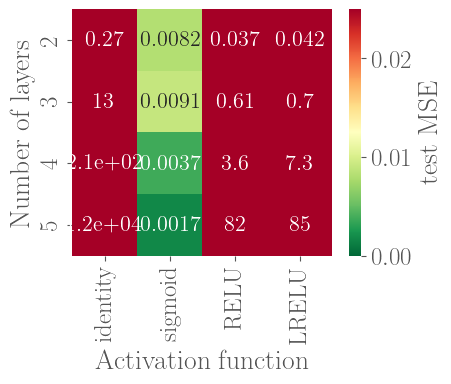

In [23]:
# plot the results
_, fig = make_plot('gridsearch')
sns.heatmap(scores_activations, annot=True, xticklabels=[act.__name__ for act in activation_funcs], yticklabels=num_layers, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.025, ax=fig)
plt.xlabel('Activation function')
plt.ylabel('Number of layers')
plt.savefig('../figures/scores_layers_activations.pdf', bbox_inches='tight')
plt.show()

### ReLU activation

In [24]:
# Repat the same for ReLU
scores_relu = np.zeros((len(num_nodes), len(num_layers)))
for i, nodes in enumerate(num_nodes):
    for j, layers in enumerate(num_layers):
        linear_regression = FFNN((input_nodes, *[nodes]*layers, output_nodes), hidden_func=RELU, output_func=identity, cost_func=CostOLS, seed=seed)
        linear_regression.reset_weights()
        result = linear_regression.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=1000, batches=10)
        scores_relu[i, j] = result['val_errors'][-1]  # Adjust this line based on the actual key in the returned dictionary
        print(f'{nodes=}, {layers=}')
clear_output()
print('Finished!')

Finished!


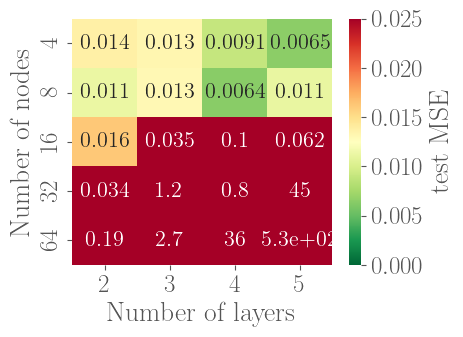

In [25]:
_, fig = make_plot('gridsearch')
sns.heatmap(scores_relu, annot=True, xticklabels=num_layers, yticklabels=num_nodes, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.025, ax=fig)

# Set the colorbar ti^cks
cbar = fig.collections[0].colorbar
cbar.set_ticks([i * 0.005 for i in range(6)])
plt.xlabel('Number of layers')
plt.ylabel('Number of nodes')
plt.savefig('../figures/scores_layer_nodes_relu.pdf', bbox_inches='tight')
plt.show()

We see that it is objectively worse than sigmoid, since signmoid performs better than RELU even for a fewer amount of nodes and layers. 

### Leaky ReLU

In [26]:
scores_leaky_relu = np.zeros((len(num_nodes), len(num_layers)))
for i, nodes in enumerate(num_nodes):
    for j, layers in enumerate(num_layers):
        print(f'{nodes=}, {layers=}')
        linear_regression = FFNN((input_nodes, *[nodes]*layers, output_nodes), hidden_func=LRELU, output_func=identity, cost_func=CostOLS, seed=seed)
        linear_regression.reset_weights()
        result = linear_regression.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=1000, batches=10)
        scores_leaky_relu[i, j] = result['val_errors'][-1]  # Adjust this line based on the actual key in the returned dictionary
clear_output()
print('Finished!')

Finished!


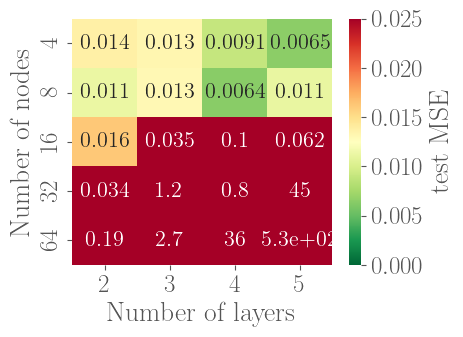

In [27]:
_, fig = make_plot('gridsearch')
sns.heatmap(scores_relu, annot=True, xticklabels=num_layers, yticklabels=num_nodes, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.025, ax=fig)

# Set the colorbar ti^cks
cbar = fig.collections[0].colorbar
cbar.set_ticks([i * 0.005 for i in range(6)])
plt.xlabel('Number of layers')
plt.ylabel('Number of nodes')
plt.savefig('../figures/scores_layer_nodes_leaky_relu.pdf', bbox_inches='tight')
plt.show()

Leaky ReLU is also objectively worse than sigmoid

## Test the best model so far for different number of epochs and batch sizes

In [28]:
## Test the best model found so far for different number of minibatches
num_batches = [1, 10, 20, 50, 100]
best_nodes = 64
best_layers = 4
scores_batch = []
linear_regression = FFNN((input_nodes, *[best_nodes]*best_layers, output_nodes), hidden_func=sigmoid, output_func=identity, cost_func=CostOLS, seed=seed)
for batch in num_batches:
    print(f'{batch=}')
    linear_regression.reset_weights()
    result = linear_regression.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=1000, batches=batch)
    scores_batch.append(result)
    print()
clear_output()
print('Finished!')

Finished!


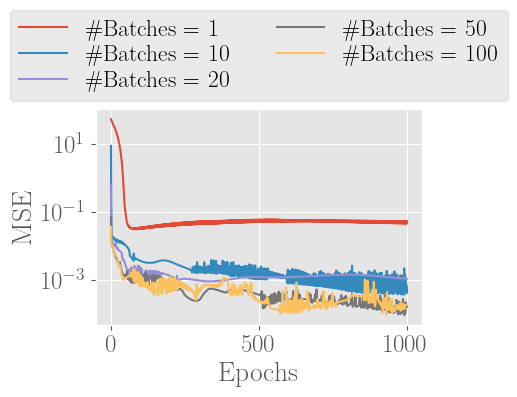

In [90]:
# plot the results
_, fig = make_plot('normal-plot')
for i, batch in enumerate(num_batches):
    plt.semilogy(scores_batch[i]['val_errors'], label=f'\\#Batches = {batch}')
plt.legend(bbox_to_anchor=(0.5,1.25), loc='center', labelspacing=0.2, ncols=2, fontsize=17)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('../figures/scores_batches_sigmoid.pdf', bbox_inches='tight')
plt.show()

## Test the best model so far for different schedulers (learning rate and regularisation parameter)

In [30]:
# We use the data from before
# We test for the schedulers: Constant, Momentum, Adagrad, AdagradMomentum, RMS_prop, Adam
best_nodes = 64
best_layers = 4 # change when results are in!
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
regularizations = [0, 1e-4, 1e-3, 1e-2]

scores_momentum = np.zeros((len(learning_rates), len(regularizations)))
scores_adagrad = np.zeros((len(learning_rates), len(regularizations)))
scores_rms_prop = np.zeros((len(learning_rates), len(regularizations)))
scores_adam = np.zeros((len(learning_rates), len(regularizations)))

schedulers = [Momentum, Adagrad, RMS_prop, Adam]


In [31]:
linear_regression = FFNN((input_nodes, *[best_nodes]*best_layers, output_nodes), hidden_func=sigmoid, output_func=identity, cost_func=CostOLS, seed=seed)
for scheduler in schedulers:
    for i, lr in enumerate(learning_rates):
        for j, reg in enumerate(regularizations):
            linear_regression.reset_weights()
            # put the result in a try except block to avoid errors
            try: 
                result = linear_regression.fit(input_train, target_train, scheduler(eta=lr), X_val=input_test, t_val=target_test, epochs=1000, batches=10, lam=reg)
            except:
                result = {'val_errors': ['NaN']}
            if scheduler == Momentum:
                scores_momentum[i, j] = result['val_errors'][-1]
            elif scheduler == Adagrad:
                scores_adagrad[i, j] = result['val_errors'][-1]
            elif scheduler == RMS_prop:
                scores_rms_prop[i, j] = result['val_errors'][-1]
            elif scheduler == Adam:
                scores_adam[i, j] = result['val_errors'][-1]
            print(f'{lr=}, {reg=}')
clear_output()
print('Finished!')

Finished!


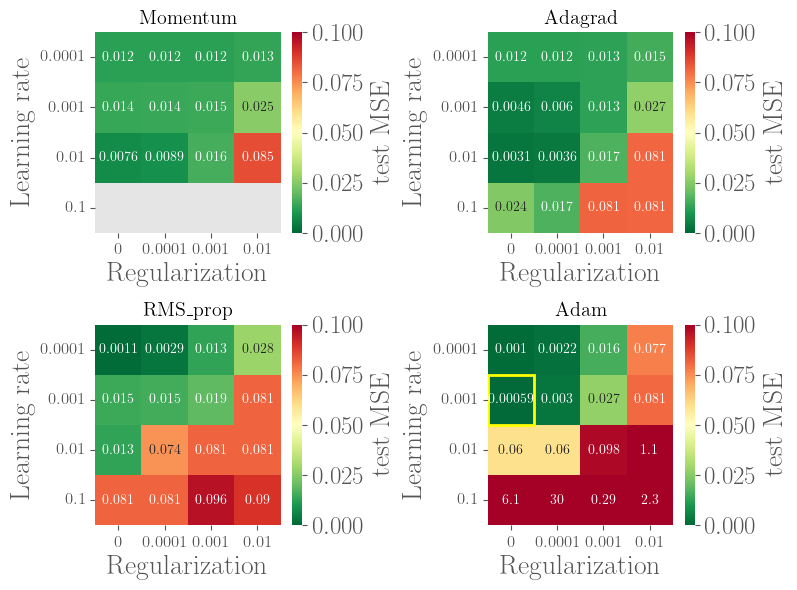

In [113]:
#plot the results
plt.figure(figsize=(8, 6))
plt.style.use('ggplot')

    # Set standardized params for each type of plot
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.subplot(2, 2, 1)
plt.grid(False)
p = sns.heatmap(scores_momentum, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.title('Momentum')
plt.setp(p.get_xticklabels(), fontsize = 'large', horizontalalignment='center', rotation=0)
plt.setp(p.get_yticklabels(), fontsize = 'large', horizontalalignment='right')

plt.subplot(2, 2, 2)
p = sns.heatmap(scores_adagrad, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.title('Adagrad')
plt.setp(p.get_xticklabels(), fontsize = 'large', horizontalalignment='center', rotation=0)
plt.setp(p.get_yticklabels(), fontsize = 'large', horizontalalignment='right')

plt.subplot(2, 2, 3)
p = sns.heatmap(scores_rms_prop, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.title('RMS_prop')
plt.setp(p.get_xticklabels(), fontsize = 'large', horizontalalignment='center', rotation=0)
plt.setp(p.get_yticklabels(), fontsize = 'large', horizontalalignment='right')

plt.subplot(2, 2, 4)
p = sns.heatmap(scores_adam, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.title('Adam')
plt.setp(p.get_xticklabels(), fontsize = 'large', horizontalalignment='center', rotation=0)
plt.setp(p.get_yticklabels(), fontsize = 'large', horizontalalignment='right')


p.add_patch(Rectangle((0, 1), 1, 1, fill=False, edgecolor='yellow', lw=2))
plt.tight_layout()
plt.savefig('../figures/FFNN_regression_sigmoid_8n_2l_compare_schedulers.pdf')
plt.show()


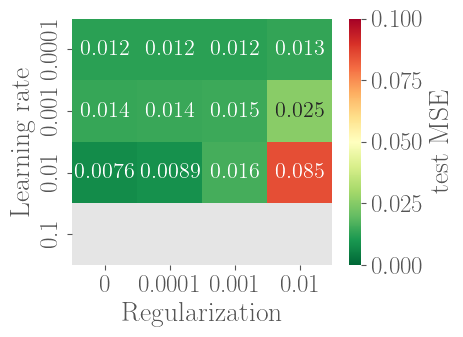

In [114]:
# plot the results one by one for saving as done with the other scores
_, fig = make_plot('gridsearch')
sns.heatmap(scores_momentum, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.1) # adjust the vmin and vmax 
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.grid(False)
plt.savefig('../figures/scores_momentum.pdf', bbox_inches='tight')
plt.show()



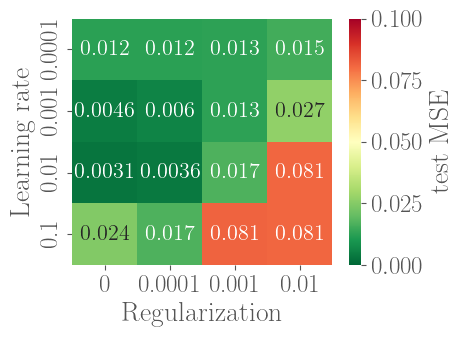

In [47]:
# repeat for adagrad
_, fig = make_plot('gridsearch')
sns.heatmap(scores_adagrad, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.1) # adjust the vmin and vmax
plt.xlabel('Regularization')
plt.ylabel('Learning rate')

plt.savefig('../figures/scores_adagrad.pdf', bbox_inches='tight')
plt.show()


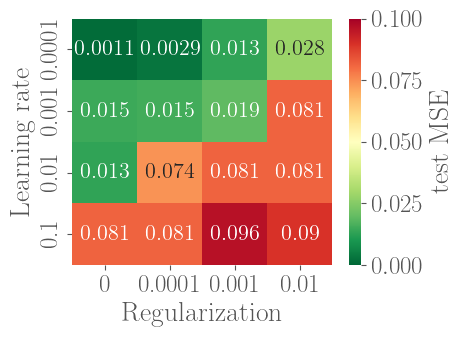

In [48]:
# RMSprop
_, fig = make_plot('gridsearch')
sns.heatmap(scores_rms_prop, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.1) # adjust the vmin and vmax
plt.xlabel('Regularization')
plt.ylabel('Learning rate')

plt.savefig('../figures/scores_rms_prop.pdf', bbox_inches='tight')
plt.show()


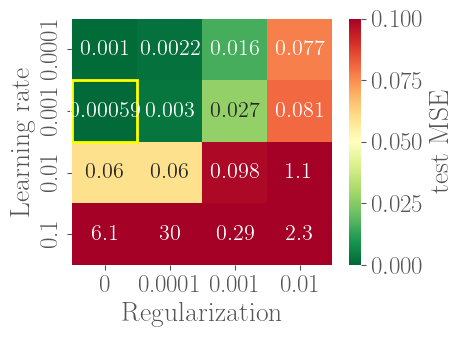

In [120]:
# adam 
_, fig = make_plot('gridsearch')
p = sns.heatmap(scores_adam, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn_r', cbar=True, cbar_kws={'label': 'test MSE'}, vmin=0, vmax=0.1) # adjust the vmin and vmax
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
p.add_patch(Rectangle((0, 1), 1, 1, fill=False, edgecolor='yellow', lw=2))

plt.savefig('../figures/scores_adam.pdf', bbox_inches='tight')
plt.show()


## Plot the predicted surface with the FFNN 

In [37]:
# test the best model with the best parameters
best_nodes = 64
best_layers = 4
best_lr = 1e-3
best_reg = 0

linear_regression = FFNN((input_nodes, *[best_nodes]*best_layers, output_nodes), hidden_func=sigmoid, output_func=identity, cost_func=CostOLS, seed=seed)
linear_regression.reset_weights()
scheduler = Adam(eta=best_lr)
result = linear_regression.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=1000, batches=10, lam=best_reg)
preds = linear_regression.predict(input)

Adam: Eta=0.001, Lambda=0
  [=======================================>] 100.0% | train_error: 0.000532 | val_error: 0.000594 

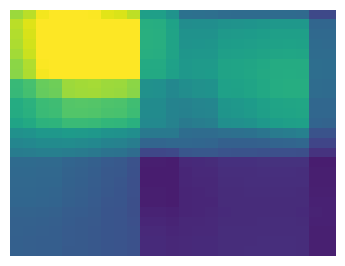

In [38]:
# plot the results
_, fig = make_plot('half-width')
sns.heatmap(preds.reshape(Z.shape), cmap='viridis', cbar=False, vmin=0, vmax=1)
plt.axis('off')

plt.savefig('../figures/ffnn_best_franke.pdf', bbox_inches='tight')
plt.show()

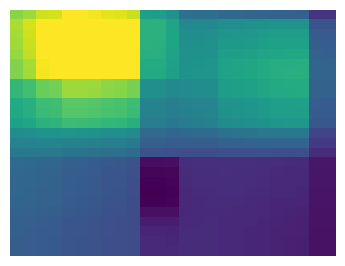

In [39]:
# plot the original franke function
_, fig = make_plot('half-width')
sns.heatmap(Z, cmap='viridis', cbar=False, vmin=0, vmax=1)
plt.axis('off')

plt.savefig('../figures/franke.pdf', bbox_inches='tight')
plt.show()


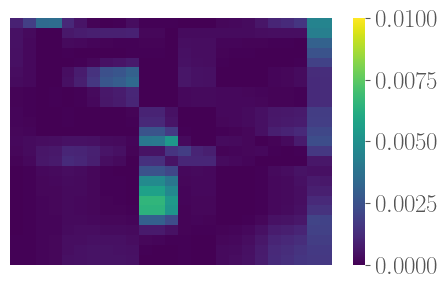

In [56]:
# plot the difference in squared error
#_, fig = make_plot('half-width')
fig = plt.figure(figsize=(5.2, 3.2))
sns.heatmap((Z-preds.reshape(Z.shape))**2, cmap='viridis', cbar=True, vmin=0, vmax=0.01)
plt.axis('off')

plt.savefig('../figures/ffnn_franke_square_error.pdf', bbox_inches='tight')
plt.show()


## Plotting bias variance tradeoff

In [41]:
N = 25
np.random.seed(seed)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
X, Y = np.meshgrid(x, y)
Z = FrankeFunction(X, Y)
# add noise to Z
# Z = Z + np.random.normal(0, 1, size=Z.shape) * 0.01

In [42]:
# Run OLS and Ridge regression on the data using no hidden layers
# using the neural network class
D = create_X(X, Y, 5)
input = D 
target = Z.reshape(-1, 1)

input_train, input_test, target_train, target_test = train_test_split(input, target, test_size=0.2)

input_nodes = input.shape[1]
output_nodes = target.shape[1]

lr = 1e-3
lam = 1e-3
scheduler = Adam(eta=lr)
lin_network = FFNN((input_nodes, output_nodes), hidden_func=identity, output_func=identity, cost_func=CostOLS, seed=seed)#, calculate_r2=True)

lin_network.reset_weights()
result_ols = lin_network.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=2000, batches=10, lam=0)

lin_network.reset_weights()
result_ridge = lin_network.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=2000, batches=10, lam=lam)




Adam: Eta=0.001, Lambda=0
  [=======================================>] 100.0% | train_error: 0.00730 | val_error: 0.00820 Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | train_error: 0.0109 | val_error: 0.0110  

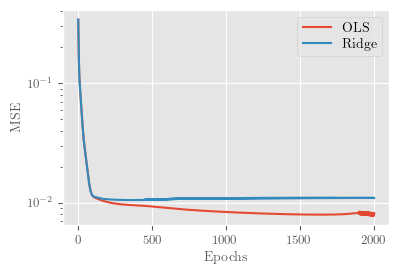

In [43]:
# Plot the results from OLS and Ridge
_, fig = make_plot('standard')
# plt.plot(result_ols['train_errors'], label='OLS train')
plt.plot(result_ols['val_errors'], label='OLS')
# plt.plot(result_ridge['train_errors'], label='Ridge train')
plt.plot(result_ridge['val_errors'], label='Ridge')
plt.yscale('log')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('../figures/ols_ridge_franke.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Repeat the same experiment, but now with a simple nerual network with 
# two hidden layers with 8 nodes each
# This time we use the Data directly from the meshgrid as inputs instead of the 
# design matrix
input = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
input_nodes = input.shape[1]
output_nodes = target.shape[1]
hidden_nodes = 8
hidden_layers = 2

input_train, input_test, target_train, target_test = train_test_split(input, target, test_size=0.2)

lr = 1e-3
lam = 1e-3
scheduler = Adam(eta=lr)
log_network = FFNN((input_nodes, *[hidden_nodes]*hidden_layers, output_nodes), hidden_func=sigmoid, output_func=identity, cost_func=CostOLS, seed=seed)

log_network.reset_weights()
result_adam = log_network.fit(input_train, target_train, scheduler, X_val=input_test, t_val=target_test, epochs=2500, batches=10, lam=lam)




Adam: Eta=0.001, Lambda=0.001
  [=======================================>] 100.0% | train_error: 0.0193 | val_error: 0.0159  

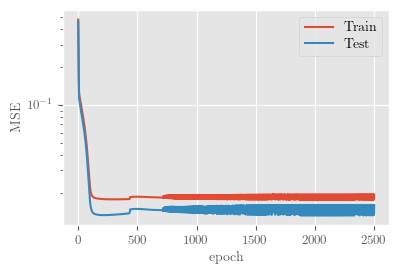

In [ ]:
# plot the mse for test and train
fig, _ = make_plot('standard')
plt.plot(result_adam['train_errors'], label='Train')
plt.plot(result_adam['val_errors'], label='Test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()